In [202]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =(12,9)
import os
import copy
from IPython.display import clear_output
import torch
from torchvision import transforms
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader,Subset
from torch.autograd import Variable
import PIL
import torch.optim as optim
import compression as comp
import time

In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# define the dataloader and load the data 

In [113]:
# initialize the dataloader and normalize the data 
class Dataset:
    """load the image / encoded object position representation pairs for training and testing data"""
    def __init__(self, path, mode = 'train'):
        self.path=path
        self.mode=mode
    def __getitem__(self, index):
        mode = self.mode
        if mode=='train':
            fname = '/train-%05d.jpg'
        elif mode=='test':
            fname = '/test-%05d.jpg'
            
        if mode=='train':
            fname1 = 'train-comp-%05d.npy'
        elif mode=='test':
            fname1 = 'test-comp-%05d.npy'
        img = PIL.Image.open(self.path+fname%index)
        vect = np.load(self.path+fname1%index)
        transform = transforms.Compose([#transforms.Scale((227,227)),
                                        transforms.ToTensor(),
                                        #transforms.Normalize(mean=[0.5],std=[0.25])
                                       ])
        img = transform(img)
        if mode=='train':
            img.requires_grad=True
        vect = torch.FloatTensor(np.concatenate(vect)) 
        return img, vect 

    def __len__(self):
        return len([f for f in os.listdir(self.path) if f.endswith('.jpg')])

# Initialize dataset iterators and find gpu if available 
train_data = Dataset('./data/training/',mode='train')
test_data = Dataset('./data/testing/',mode='test')
print('data is loaded')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device is '+ str(device))

data is loaded
device is cuda:0


# define the cnn

In [ ]:
class Net(nn.Module):
    """ this is a hacked up alexnet where the depth of layers is modified to accomodate grayscale wihtout overfitting """
    def __init__(self):
        super(Net, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1,32,11,4,2),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(3,2,0,1),
                                     nn.Conv2d(32,96,5,1,2),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(3,2,0,1),
                                     nn.Conv2d(96,96*3,3,1,1),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(96*3,96*2,3,1,1),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(96*2,96*2,3,1,1),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(3,2,0,1)
                                    )
        self.fcnet = nn.Sequential(nn.Dropout(),
                          nn.Linear(192*3**2,192*3**2//2),
                          nn.ReLU(inplace=True),
                          nn.Dropout(),
                          nn.Linear(192*3**2//2,192*3**2//2),
                          nn.ReLU(inplace=True),
                          nn.Linear(192*3**2//2,500)
                          )
    def forward(self, img):
        output = self.convnet(img)
        output = output.view(-1, 192*3**2)
        output = self.fcnet(output)
        return output

# overfit on one sample


In [282]:
x,y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

In [261]:
model = Net().to(device).train()

In [284]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for i in range(50000):
    optimizer.zero_grad() # zero gradients
    y_ = model(x)
    loss = criterion(y_,y)
    if i%10==0:
        clear_output(wait=True)
        print(loss.cpu().data.item()/k)

    loss.backward()
    optimizer.step()

108.140673828125


KeyboardInterrupt: 

In [276]:
model = model.eval()
y_ = model(x).detach().cpu().numpy()
y = y.cpu().numpy()
model = model.train()

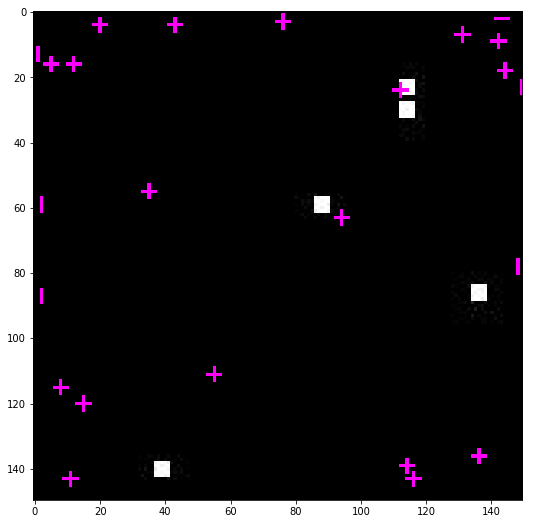

In [280]:
n = 5 # number to investigate 
S = np.load('./data/sensing_matrix.npy')
shape = (150,150)
L = 5
M = int(round(np.sqrt(2)*150))
pts = comp.decompress(y_[n].reshape(5,100),S,shape,L,M)
im = x[n].cpu().detach().numpy().squeeze()
for p in pts:
    im=comp.draw_plus(p,im)
plt.imshow(im)

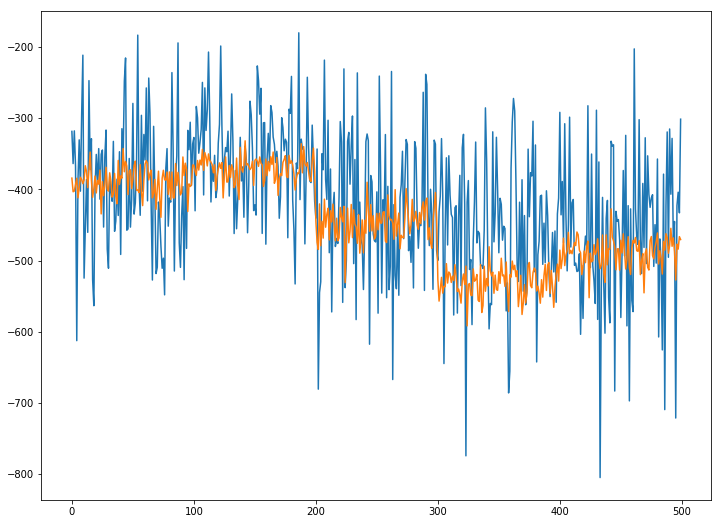

In [226]:
n = 33
plt.plot(y[n])
plt.plot(y_[n])

In [189]:
# totally works on 1 sample. it will work on all of them. 

# train the network 

In [285]:
# initialize the model 
model = Net().to(device).train()

In [288]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
train_losses = []
val_losses = []
min_val_loss = 999999.9 # for early stopping 

# set up the training loop and dataset iterator 
k = 200 #size of batch 
N = 5000 #number epochs
b = int(len(train_data)/k) #number of batches
train_loader = DataLoader(train_data , batch_size = k, shuffle = True) #batch data loader
test_loader = DataLoader(test_data, batch_size = k, shuffle = False)

# train the network N epochs through the dataset 
for epoch in range(N): # epoch iterator 
    train_loss = 0 # mean loss per epoch 
    t0 = time.time() # to estimate claculation time per epoch 
    for i, (inputs, targets) in enumerate(train_loader): # batch iterator 
        inputs, targets = inputs.to(device), targets.to(device) # batch to gpu
        optimizer.zero_grad() # zero gradients
        outputs = model(inputs) # model prediction
        loss = criterion(outputs, targets)  # loss computation
        loss.backward() # backpropagation
        optimizer.step() # gradient descent 
        train_loss += loss.cpu().data.item()/k # average loss across a batch 
    train_loss /= i # average loss across an epoch 
    print('epoch {} completed in {} seconds with avg training loss {}'.format(epoch,
                                                                              round((time.time()-t0), 2),
                                                                              round(train_loss, 2)
                                                                             ))
    train_losses.append(train_loss)
    scheduler.step(train_loss) # possibly modify the learning rate if avg training loss has plateaued
    
    if epoch%5==0:  # early stopping 
        # calculate the avg validation loss per batch
        val_loss = 0 
        for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device) # batch to gpu
            outputs = model(inputs) # model prediction
            loss = criterion(outputs, targets)
            val_loss += loss.cpu().data.item()/k # average loss over validation batch 
        val_loss /= i 
        val_losses.append(val_loss)
        if val_loss < min_val_loss:
            min_val_loss = val_loss 
            torch.save(model.state_dict(),'earlystop.pt') # save partially trained model 
            print('model saved (early stop). ', 'validation loss was ', min_val_loss)
        else:
            print('model not saved. validation loss was ', val_loss)

epoch 0 completed in 27.11 seconds with avg training loss 324.93
model saved (early stop).  validation loss was  816.38599609375
epoch 1 completed in 26.35 seconds with avg training loss 322.4
epoch 2 completed in 26.47 seconds with avg training loss 322.97
epoch 3 completed in 26.66 seconds with avg training loss 319.76
epoch 4 completed in 26.06 seconds with avg training loss 319.61
epoch 5 completed in 26.34 seconds with avg training loss 320.06
model not saved. validation loss was  877.97365234375
epoch 6 completed in 25.78 seconds with avg training loss 319.82
epoch 7 completed in 26.19 seconds with avg training loss 318.73
epoch 8 completed in 25.77 seconds with avg training loss 318.8
epoch 9 completed in 26.28 seconds with avg training loss 316.93
epoch 10 completed in 25.95 seconds with avg training loss 319.02
model saved (early stop).  validation loss was  812.7486132812501
epoch 11 completed in 26.17 seconds with avg training loss 316.71
epoch 12 completed in 26.08 seconds 

model not saved. validation loss was  788.655
epoch 106 completed in 26.78 seconds with avg training loss 306.07
epoch 107 completed in 26.61 seconds with avg training loss 306.2
epoch 108 completed in 27.02 seconds with avg training loss 306.44
epoch 109 completed in 26.45 seconds with avg training loss 305.9
Epoch   109: reducing learning rate of group 0 to 1.0000e-05.
epoch 110 completed in 26.56 seconds with avg training loss 305.93
model not saved. validation loss was  800.3966601562499
epoch 111 completed in 26.44 seconds with avg training loss 306.61
epoch 112 completed in 26.69 seconds with avg training loss 305.75
epoch 113 completed in 26.63 seconds with avg training loss 306.1
epoch 114 completed in 26.73 seconds with avg training loss 306.2
epoch 115 completed in 26.58 seconds with avg training loss 306.41
model not saved. validation loss was  806.1481640625
epoch 116 completed in 26.77 seconds with avg training loss 306.85
epoch 117 completed in 26.58 seconds with avg trai

epoch 208 completed in 26.77 seconds with avg training loss 306.13
epoch 209 completed in 26.92 seconds with avg training loss 306.06
epoch 210 completed in 26.72 seconds with avg training loss 306.08
model not saved. validation loss was  810.40435546875
epoch 211 completed in 26.84 seconds with avg training loss 306.0
epoch 212 completed in 26.66 seconds with avg training loss 305.88
epoch 213 completed in 26.98 seconds with avg training loss 306.45
epoch 214 completed in 27.3 seconds with avg training loss 306.52
epoch 215 completed in 26.83 seconds with avg training loss 306.32
model not saved. validation loss was  799.7993945312501
epoch 216 completed in 26.77 seconds with avg training loss 306.6
epoch 217 completed in 26.89 seconds with avg training loss 306.28
epoch 218 completed in 26.5 seconds with avg training loss 306.14
epoch 219 completed in 26.36 seconds with avg training loss 305.82
epoch 220 completed in 26.91 seconds with avg training loss 305.82
model not saved. valida

epoch 314 completed in 27.05 seconds with avg training loss 306.14
epoch 315 completed in 27.28 seconds with avg training loss 306.5
model not saved. validation loss was  805.9923632812499
epoch 316 completed in 27.22 seconds with avg training loss 305.99
epoch 317 completed in 27.03 seconds with avg training loss 305.81
epoch 318 completed in 26.91 seconds with avg training loss 305.8
epoch 319 completed in 26.97 seconds with avg training loss 306.37
epoch 320 completed in 26.98 seconds with avg training loss 306.04
model not saved. validation loss was  800.0200390625
epoch 321 completed in 26.88 seconds with avg training loss 306.6
epoch 322 completed in 26.67 seconds with avg training loss 305.68
epoch 323 completed in 27.0 seconds with avg training loss 306.27
epoch 324 completed in 26.84 seconds with avg training loss 306.37
epoch 325 completed in 27.08 seconds with avg training loss 305.99
model not saved. validation loss was  801.35544921875
epoch 326 completed in 27.75 seconds 

epoch 420 completed in 26.3 seconds with avg training loss 306.07
model not saved. validation loss was  803.785390625
epoch 421 completed in 26.72 seconds with avg training loss 306.12
epoch 422 completed in 27.14 seconds with avg training loss 306.13
epoch 423 completed in 27.42 seconds with avg training loss 305.8
epoch 424 completed in 26.7 seconds with avg training loss 306.06
epoch 425 completed in 26.94 seconds with avg training loss 305.87
model not saved. validation loss was  809.2802148437501
epoch 426 completed in 26.56 seconds with avg training loss 306.35
epoch 427 completed in 26.95 seconds with avg training loss 306.01
epoch 428 completed in 27.11 seconds with avg training loss 305.98
epoch 429 completed in 26.77 seconds with avg training loss 305.97
epoch 430 completed in 26.38 seconds with avg training loss 306.13
model not saved. validation loss was  811.58259765625
epoch 431 completed in 26.63 seconds with avg training loss 305.99
epoch 432 completed in 26.73 seconds 

model not saved. validation loss was  806.6598828125001
epoch 526 completed in 27.16 seconds with avg training loss 305.82
epoch 527 completed in 27.63 seconds with avg training loss 305.64
epoch 528 completed in 26.94 seconds with avg training loss 306.66
epoch 529 completed in 26.86 seconds with avg training loss 306.25
epoch 530 completed in 27.17 seconds with avg training loss 305.96
model not saved. validation loss was  799.5964453125
epoch 531 completed in 26.97 seconds with avg training loss 306.0
epoch 532 completed in 27.22 seconds with avg training loss 306.16
epoch 533 completed in 26.69 seconds with avg training loss 306.16
epoch 534 completed in 26.5 seconds with avg training loss 306.15
epoch 535 completed in 27.13 seconds with avg training loss 306.28
model not saved. validation loss was  801.95578125
epoch 536 completed in 26.48 seconds with avg training loss 306.54
epoch 537 completed in 26.78 seconds with avg training loss 306.34
epoch 538 completed in 27.13 seconds w

epoch 631 completed in 26.94 seconds with avg training loss 306.16
epoch 632 completed in 27.19 seconds with avg training loss 306.48
epoch 633 completed in 27.48 seconds with avg training loss 306.18
epoch 634 completed in 26.97 seconds with avg training loss 306.29
epoch 635 completed in 27.11 seconds with avg training loss 305.95
model not saved. validation loss was  803.404765625
epoch 636 completed in 26.88 seconds with avg training loss 306.38
epoch 637 completed in 26.66 seconds with avg training loss 305.94
epoch 638 completed in 27.03 seconds with avg training loss 305.97
epoch 639 completed in 26.73 seconds with avg training loss 306.0
epoch 640 completed in 26.44 seconds with avg training loss 306.33
model not saved. validation loss was  807.27453125
epoch 641 completed in 27.23 seconds with avg training loss 306.02
epoch 642 completed in 26.88 seconds with avg training loss 305.94
epoch 643 completed in 27.73 seconds with avg training loss 306.18
epoch 644 completed in 27.1

epoch 737 completed in 27.23 seconds with avg training loss 305.77
epoch 738 completed in 27.05 seconds with avg training loss 306.7
epoch 739 completed in 27.27 seconds with avg training loss 305.71
epoch 740 completed in 27.13 seconds with avg training loss 306.44
model not saved. validation loss was  806.025078125
epoch 741 completed in 27.25 seconds with avg training loss 306.36
epoch 742 completed in 27.13 seconds with avg training loss 306.36
epoch 743 completed in 27.0 seconds with avg training loss 306.45
epoch 744 completed in 27.56 seconds with avg training loss 306.66
epoch 745 completed in 27.22 seconds with avg training loss 306.13
model not saved. validation loss was  806.17201171875
epoch 746 completed in 27.22 seconds with avg training loss 306.53
epoch 747 completed in 27.55 seconds with avg training loss 306.2
epoch 748 completed in 27.34 seconds with avg training loss 306.27
epoch 749 completed in 27.48 seconds with avg training loss 305.98
epoch 750 completed in 27.

epoch 843 completed in 27.47 seconds with avg training loss 306.49
epoch 844 completed in 27.38 seconds with avg training loss 306.47
epoch 845 completed in 26.94 seconds with avg training loss 306.04
model not saved. validation loss was  798.56166015625
epoch 846 completed in 27.36 seconds with avg training loss 306.39
epoch 847 completed in 26.98 seconds with avg training loss 305.99
epoch 848 completed in 27.28 seconds with avg training loss 306.22
epoch 849 completed in 27.0 seconds with avg training loss 306.1
epoch 850 completed in 26.78 seconds with avg training loss 306.31
model not saved. validation loss was  803.270859375
epoch 851 completed in 27.09 seconds with avg training loss 306.63
epoch 852 completed in 26.94 seconds with avg training loss 306.13
epoch 853 completed in 26.91 seconds with avg training loss 306.29
epoch 854 completed in 26.63 seconds with avg training loss 306.12
epoch 855 completed in 26.98 seconds with avg training loss 305.97
model not saved. validati

epoch 949 completed in 27.2 seconds with avg training loss 305.79
epoch 950 completed in 26.95 seconds with avg training loss 306.31
model not saved. validation loss was  814.2908398437501
epoch 951 completed in 27.17 seconds with avg training loss 305.88
epoch 952 completed in 26.67 seconds with avg training loss 305.84
epoch 953 completed in 27.08 seconds with avg training loss 306.17
epoch 954 completed in 26.92 seconds with avg training loss 305.81
epoch 955 completed in 27.36 seconds with avg training loss 306.34
model not saved. validation loss was  803.058515625
epoch 956 completed in 26.86 seconds with avg training loss 305.84
epoch 957 completed in 27.0 seconds with avg training loss 306.15
epoch 958 completed in 27.2 seconds with avg training loss 306.2
epoch 959 completed in 26.59 seconds with avg training loss 306.15
epoch 960 completed in 26.88 seconds with avg training loss 306.37
model not saved. validation loss was  806.67001953125
epoch 961 completed in 26.75 seconds w

epoch 1054 completed in 26.41 seconds with avg training loss 305.93
epoch 1055 completed in 26.61 seconds with avg training loss 305.81
model not saved. validation loss was  807.2160546875
epoch 1056 completed in 26.94 seconds with avg training loss 306.21
epoch 1057 completed in 26.48 seconds with avg training loss 305.99
epoch 1058 completed in 26.88 seconds with avg training loss 306.21
epoch 1059 completed in 27.03 seconds with avg training loss 306.21
epoch 1060 completed in 26.77 seconds with avg training loss 306.4
model not saved. validation loss was  803.4180078125
epoch 1061 completed in 26.44 seconds with avg training loss 305.78
epoch 1062 completed in 26.64 seconds with avg training loss 306.52
epoch 1063 completed in 26.66 seconds with avg training loss 305.56
epoch 1064 completed in 27.05 seconds with avg training loss 306.32
epoch 1065 completed in 26.48 seconds with avg training loss 306.6
model not saved. validation loss was  813.5914453124999
epoch 1066 completed in 

epoch 1159 completed in 27.23 seconds with avg training loss 306.2
epoch 1160 completed in 27.42 seconds with avg training loss 306.21
model not saved. validation loss was  803.311953125
epoch 1161 completed in 27.08 seconds with avg training loss 306.15
epoch 1162 completed in 27.0 seconds with avg training loss 305.98
epoch 1163 completed in 26.97 seconds with avg training loss 306.1
epoch 1164 completed in 27.3 seconds with avg training loss 306.2
epoch 1165 completed in 27.05 seconds with avg training loss 306.58
model not saved. validation loss was  806.32
epoch 1166 completed in 27.34 seconds with avg training loss 306.76
epoch 1167 completed in 27.45 seconds with avg training loss 306.01
epoch 1168 completed in 27.13 seconds with avg training loss 306.12
epoch 1169 completed in 26.97 seconds with avg training loss 306.34
epoch 1170 completed in 26.98 seconds with avg training loss 306.45
model not saved. validation loss was  807.6836328125
epoch 1171 completed in 27.06 seconds w

epoch 1264 completed in 26.75 seconds with avg training loss 305.67
epoch 1265 completed in 27.5 seconds with avg training loss 306.49
model not saved. validation loss was  806.99177734375
epoch 1266 completed in 27.58 seconds with avg training loss 306.01
epoch 1267 completed in 27.16 seconds with avg training loss 306.14
epoch 1268 completed in 27.41 seconds with avg training loss 306.25
epoch 1269 completed in 26.97 seconds with avg training loss 305.97
epoch 1270 completed in 26.67 seconds with avg training loss 306.09
model not saved. validation loss was  813.73603515625
epoch 1271 completed in 27.03 seconds with avg training loss 306.37
epoch 1272 completed in 26.75 seconds with avg training loss 306.41
epoch 1273 completed in 27.0 seconds with avg training loss 306.13
epoch 1274 completed in 27.0 seconds with avg training loss 306.43
epoch 1275 completed in 26.34 seconds with avg training loss 306.34
model not saved. validation loss was  809.6546679687501
epoch 1276 completed in

epoch 1369 completed in 27.47 seconds with avg training loss 305.69
epoch 1370 completed in 27.78 seconds with avg training loss 305.83
model not saved. validation loss was  805.2157421874999
epoch 1371 completed in 27.77 seconds with avg training loss 306.27
epoch 1372 completed in 27.08 seconds with avg training loss 306.14
epoch 1373 completed in 26.89 seconds with avg training loss 306.0
epoch 1374 completed in 27.56 seconds with avg training loss 306.14
epoch 1375 completed in 27.33 seconds with avg training loss 305.93
model not saved. validation loss was  800.6002734375
epoch 1376 completed in 27.03 seconds with avg training loss 305.92
epoch 1377 completed in 27.48 seconds with avg training loss 306.9
epoch 1378 completed in 27.44 seconds with avg training loss 306.33
epoch 1379 completed in 27.53 seconds with avg training loss 306.17
epoch 1380 completed in 27.11 seconds with avg training loss 306.63
model not saved. validation loss was  802.606171875
epoch 1381 completed in 2

epoch 1474 completed in 27.05 seconds with avg training loss 306.18
epoch 1475 completed in 26.8 seconds with avg training loss 306.61
model not saved. validation loss was  801.798125
epoch 1476 completed in 27.38 seconds with avg training loss 305.89
epoch 1477 completed in 27.08 seconds with avg training loss 305.91
epoch 1478 completed in 27.19 seconds with avg training loss 306.63
epoch 1479 completed in 27.31 seconds with avg training loss 306.12
epoch 1480 completed in 27.06 seconds with avg training loss 306.61
model not saved. validation loss was  798.5910351562501
epoch 1481 completed in 27.3 seconds with avg training loss 305.59
epoch 1482 completed in 27.28 seconds with avg training loss 306.12
epoch 1483 completed in 27.19 seconds with avg training loss 306.6
epoch 1484 completed in 26.86 seconds with avg training loss 306.44
epoch 1485 completed in 27.33 seconds with avg training loss 306.11
model not saved. validation loss was  808.4225195312499
epoch 1486 completed in 26

epoch 1579 completed in 27.59 seconds with avg training loss 306.48
epoch 1580 completed in 27.73 seconds with avg training loss 306.84
model not saved. validation loss was  802.8599218749999
epoch 1581 completed in 27.16 seconds with avg training loss 306.4
epoch 1582 completed in 26.97 seconds with avg training loss 306.27
epoch 1583 completed in 27.55 seconds with avg training loss 306.23
epoch 1584 completed in 27.25 seconds with avg training loss 306.23
epoch 1585 completed in 27.78 seconds with avg training loss 306.57
model not saved. validation loss was  804.7760156249999
epoch 1586 completed in 27.5 seconds with avg training loss 305.95
epoch 1587 completed in 27.22 seconds with avg training loss 306.33
epoch 1588 completed in 27.48 seconds with avg training loss 306.41
epoch 1589 completed in 26.48 seconds with avg training loss 306.46
epoch 1590 completed in 27.03 seconds with avg training loss 305.94
model not saved. validation loss was  809.7665625
epoch 1591 completed in 

epoch 1684 completed in 27.14 seconds with avg training loss 306.17
epoch 1685 completed in 26.97 seconds with avg training loss 306.09
model not saved. validation loss was  813.27958984375
epoch 1686 completed in 27.33 seconds with avg training loss 305.95
epoch 1687 completed in 27.36 seconds with avg training loss 305.94
epoch 1688 completed in 27.36 seconds with avg training loss 305.83
epoch 1689 completed in 27.34 seconds with avg training loss 306.61
epoch 1690 completed in 28.09 seconds with avg training loss 306.51
model not saved. validation loss was  806.016953125
epoch 1691 completed in 27.48 seconds with avg training loss 306.16
epoch 1692 completed in 27.08 seconds with avg training loss 306.09
epoch 1693 completed in 27.2 seconds with avg training loss 306.43
epoch 1694 completed in 27.16 seconds with avg training loss 306.2
epoch 1695 completed in 27.06 seconds with avg training loss 306.23
model not saved. validation loss was  798.96240234375
epoch 1696 completed in 27

epoch 1789 completed in 27.0 seconds with avg training loss 306.49
epoch 1790 completed in 27.19 seconds with avg training loss 306.43
model not saved. validation loss was  812.7578515625
epoch 1791 completed in 26.89 seconds with avg training loss 306.1
epoch 1792 completed in 26.83 seconds with avg training loss 306.0
epoch 1793 completed in 26.86 seconds with avg training loss 306.16
epoch 1794 completed in 26.86 seconds with avg training loss 305.72
epoch 1795 completed in 27.2 seconds with avg training loss 306.31
model not saved. validation loss was  805.85900390625
epoch 1796 completed in 27.31 seconds with avg training loss 306.15
epoch 1797 completed in 27.2 seconds with avg training loss 306.27
epoch 1798 completed in 27.09 seconds with avg training loss 306.58
epoch 1799 completed in 27.48 seconds with avg training loss 306.08
epoch 1800 completed in 26.94 seconds with avg training loss 306.33
model not saved. validation loss was  801.75322265625
epoch 1801 completed in 27.1

epoch 1894 completed in 27.33 seconds with avg training loss 306.26
epoch 1895 completed in 26.66 seconds with avg training loss 306.06
model not saved. validation loss was  810.2762695312499
epoch 1896 completed in 27.03 seconds with avg training loss 306.39
epoch 1897 completed in 26.77 seconds with avg training loss 306.39
epoch 1898 completed in 26.45 seconds with avg training loss 306.3
epoch 1899 completed in 26.67 seconds with avg training loss 306.43
epoch 1900 completed in 26.88 seconds with avg training loss 306.24
model not saved. validation loss was  802.8199999999999
epoch 1901 completed in 26.44 seconds with avg training loss 306.55
epoch 1902 completed in 26.42 seconds with avg training loss 306.38
epoch 1903 completed in 26.61 seconds with avg training loss 305.94
epoch 1904 completed in 26.55 seconds with avg training loss 306.87
epoch 1905 completed in 27.05 seconds with avg training loss 306.03
model not saved. validation loss was  806.1582421875
epoch 1906 completed

epoch 1999 completed in 27.39 seconds with avg training loss 306.46
epoch 2000 completed in 27.11 seconds with avg training loss 306.18
model not saved. validation loss was  805.96783203125
epoch 2001 completed in 26.94 seconds with avg training loss 305.94
epoch 2002 completed in 27.45 seconds with avg training loss 305.83
epoch 2003 completed in 26.75 seconds with avg training loss 306.6
epoch 2004 completed in 26.44 seconds with avg training loss 306.41
epoch 2005 completed in 26.44 seconds with avg training loss 306.32
model not saved. validation loss was  814.9102734374999
epoch 2006 completed in 26.75 seconds with avg training loss 306.07
epoch 2007 completed in 26.84 seconds with avg training loss 306.13
epoch 2008 completed in 26.86 seconds with avg training loss 306.26
epoch 2009 completed in 27.14 seconds with avg training loss 306.11
epoch 2010 completed in 26.75 seconds with avg training loss 306.03
model not saved. validation loss was  808.1033789062501
epoch 2011 complete

epoch 2103 completed in 26.73 seconds with avg training loss 306.33
epoch 2104 completed in 26.69 seconds with avg training loss 306.23
epoch 2105 completed in 26.78 seconds with avg training loss 306.03
model not saved. validation loss was  808.1151757812501
epoch 2106 completed in 27.06 seconds with avg training loss 305.52
epoch 2107 completed in 27.39 seconds with avg training loss 306.47
epoch 2108 completed in 27.09 seconds with avg training loss 306.06
epoch 2109 completed in 27.11 seconds with avg training loss 306.2
epoch 2110 completed in 27.02 seconds with avg training loss 306.45
model not saved. validation loss was  804.8870507812501
epoch 2111 completed in 27.25 seconds with avg training loss 306.28
epoch 2112 completed in 26.67 seconds with avg training loss 306.17
epoch 2113 completed in 27.28 seconds with avg training loss 306.36
epoch 2114 completed in 26.8 seconds with avg training loss 306.26
epoch 2115 completed in 27.0 seconds with avg training loss 306.39
model n

epoch 2207 completed in 26.84 seconds with avg training loss 306.31
epoch 2208 completed in 27.06 seconds with avg training loss 305.94
epoch 2209 completed in 27.03 seconds with avg training loss 306.47
epoch 2210 completed in 26.94 seconds with avg training loss 306.63
model not saved. validation loss was  807.08841796875
epoch 2211 completed in 27.08 seconds with avg training loss 306.52
epoch 2212 completed in 26.92 seconds with avg training loss 306.36
epoch 2213 completed in 26.31 seconds with avg training loss 306.45
epoch 2214 completed in 26.7 seconds with avg training loss 305.71
epoch 2215 completed in 26.33 seconds with avg training loss 306.33
model not saved. validation loss was  801.02470703125
epoch 2216 completed in 26.42 seconds with avg training loss 306.29
epoch 2217 completed in 27.0 seconds with avg training loss 306.38
epoch 2218 completed in 26.61 seconds with avg training loss 306.26
epoch 2219 completed in 26.47 seconds with avg training loss 306.46
epoch 2220

epoch 2312 completed in 26.91 seconds with avg training loss 306.64
epoch 2313 completed in 27.0 seconds with avg training loss 306.11
epoch 2314 completed in 26.56 seconds with avg training loss 306.21
epoch 2315 completed in 26.98 seconds with avg training loss 306.7
model not saved. validation loss was  813.605390625
epoch 2316 completed in 26.59 seconds with avg training loss 306.35
epoch 2317 completed in 26.13 seconds with avg training loss 306.23
epoch 2318 completed in 27.08 seconds with avg training loss 305.93
epoch 2319 completed in 26.61 seconds with avg training loss 306.06
epoch 2320 completed in 27.02 seconds with avg training loss 306.35
model not saved. validation loss was  811.74888671875
epoch 2321 completed in 26.86 seconds with avg training loss 306.17
epoch 2322 completed in 27.11 seconds with avg training loss 306.42
epoch 2323 completed in 26.92 seconds with avg training loss 306.1
epoch 2324 completed in 26.75 seconds with avg training loss 306.11
epoch 2325 co

epoch 2417 completed in 27.11 seconds with avg training loss 306.3
epoch 2418 completed in 27.19 seconds with avg training loss 306.5
epoch 2419 completed in 26.81 seconds with avg training loss 306.17
epoch 2420 completed in 27.06 seconds with avg training loss 306.69
model not saved. validation loss was  802.2812109375
epoch 2421 completed in 27.27 seconds with avg training loss 305.92
epoch 2422 completed in 27.28 seconds with avg training loss 306.2
epoch 2423 completed in 27.28 seconds with avg training loss 306.46
epoch 2424 completed in 27.11 seconds with avg training loss 306.48
epoch 2425 completed in 26.91 seconds with avg training loss 306.15
model not saved. validation loss was  812.7708984375
epoch 2426 completed in 27.16 seconds with avg training loss 305.88
epoch 2427 completed in 26.72 seconds with avg training loss 306.56
epoch 2428 completed in 27.25 seconds with avg training loss 306.05
epoch 2429 completed in 27.14 seconds with avg training loss 306.22
epoch 2430 co

epoch 2522 completed in 26.95 seconds with avg training loss 306.28
epoch 2523 completed in 27.08 seconds with avg training loss 305.37
epoch 2524 completed in 26.95 seconds with avg training loss 306.23
epoch 2525 completed in 27.16 seconds with avg training loss 305.83
model not saved. validation loss was  805.11572265625
epoch 2526 completed in 27.0 seconds with avg training loss 306.32
epoch 2527 completed in 27.05 seconds with avg training loss 305.96
epoch 2528 completed in 27.0 seconds with avg training loss 305.79
epoch 2529 completed in 27.14 seconds with avg training loss 306.15
epoch 2530 completed in 27.08 seconds with avg training loss 306.38
model not saved. validation loss was  806.80740234375
epoch 2531 completed in 27.0 seconds with avg training loss 306.59
epoch 2532 completed in 27.28 seconds with avg training loss 306.41
epoch 2533 completed in 26.86 seconds with avg training loss 305.65
epoch 2534 completed in 27.31 seconds with avg training loss 305.97
epoch 2535 

epoch 2626 completed in 26.83 seconds with avg training loss 306.33
epoch 2627 completed in 26.78 seconds with avg training loss 306.34
epoch 2628 completed in 27.09 seconds with avg training loss 305.83
epoch 2629 completed in 27.19 seconds with avg training loss 305.88
epoch 2630 completed in 27.02 seconds with avg training loss 306.94
model not saved. validation loss was  800.83267578125
epoch 2631 completed in 27.06 seconds with avg training loss 306.31
epoch 2632 completed in 27.34 seconds with avg training loss 305.87
epoch 2633 completed in 27.14 seconds with avg training loss 306.36
epoch 2634 completed in 26.88 seconds with avg training loss 306.71
epoch 2635 completed in 26.81 seconds with avg training loss 305.9
model not saved. validation loss was  797.62923828125
epoch 2636 completed in 26.78 seconds with avg training loss 306.54
epoch 2637 completed in 27.27 seconds with avg training loss 305.71
epoch 2638 completed in 26.63 seconds with avg training loss 305.61
epoch 263

KeyboardInterrupt: 

Text(0,0.5,'loss')

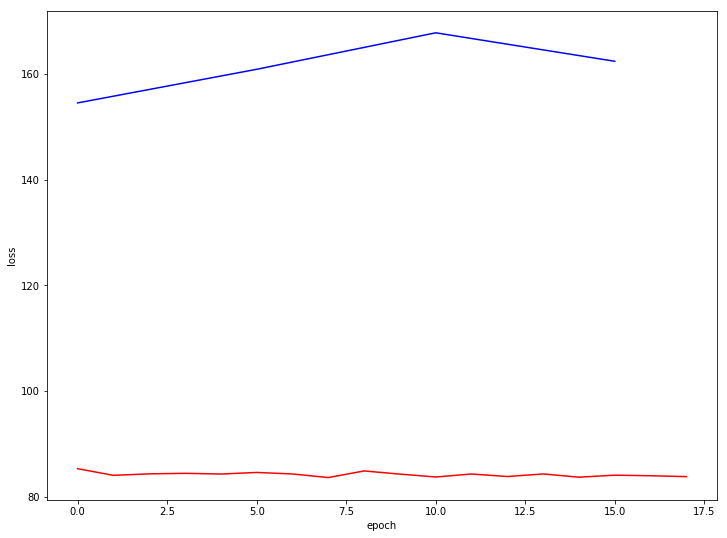

In [237]:
plt.plot(range(0,5*len(val_losses),5),val_losses,color='blue')
plt.plot(range(len(train_losses)),train_losses,color='red')
plt.xlabel('epoch')
plt.ylabel('loss')

# diagnose output by decompression / visualization 

In [ ]:
model.state_dict() = torch.load('trained.pt')
model.eval()

In [ ]:
test_loader = DataLoader(test_data , batch_size = k, shuffle = True) #batch data loader
for i,(x,y) in enumerate(test_loader):
    break
    

In [ ]:
y_ = model(x.to(device)).cpu().detach().numpy()
y = y.numpy()

In [ ]:
for n in range(3):
    plt.plot(y[n],'x')
    plt.plot(y_[n],'o')
    plt.show()

In [ ]:
S = np.load('./data/sensing_matrix.npy')
shape = x[0].numpy().shape[1:]
_,M = shape
N = 100
L = 5

In [ ]:
Y = y_[0]
Y = Y.reshape(L,N)

In [ ]:
pts = comp.unproject(F,shape,5,M)

In [ ]:
im = x[0].numpy().squeeze()
for p in pts:
    im = comp.draw_plus(p,im)
plt.imshow(im,cmap='gray')

In [ ]:
mask = (pts.T[0]>0)&(pts.T[0]<150)&(pts.T[1]>0)&(pts.T[1]<150)
np.where(mask)